<a href="https://colab.research.google.com/github/amulyagupta1278/Coding-Projects/blob/Deep-Learning/Lab5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Segmentation using Deep Learning

In [ ]:
import torch
from torch import nn
import torchvision
from PIL import Image

import os
from pathlib import Path

Data setup

In [ ]:
!pip install --upgrade --no-cache-dir gdown >./tmp
!gdown --id 1HUq0Hk0FYqxlc0BHWhYtsjLC65oTJ2dY

Downloading...
From: https://drive.google.com/uc?id=1HUq0Hk0FYqxlc0BHWhYtsjLC65oTJ2dY
To: /content/Portrait.zip
100% 107M/107M [00:00<00:00, 204MB/s] 


In [ ]:
!ls

Portrait.zip  sample_data  tmp


In [ ]:
!mkdir portraits
!unzip Portrait.zip -d portraits >./tmp
%cd portraits

/content/portraits


In [ ]:
!ls

EG1800_train.txt  EG1800_val.txt  GT_png  images_data_crop  train.txt  val.txt


In [ ]:
!cd images_data_crop && ls

00001.jpg  00254.jpg  00509.jpg  00778.jpg  01065.jpg  02062.jpg  02349.jpg
00002.jpg  00255.jpg  00510.jpg  00779.jpg  01066.jpg  02063.jpg  02351.jpg
00003.jpg  00256.jpg  00511.jpg  00780.jpg  01067.jpg  02064.jpg  02352.jpg
00004.jpg  00259.jpg  00512.jpg  00781.jpg  01068.jpg  02065.jpg  02353.jpg
00005.jpg  00260.jpg  00513.jpg  00782.jpg  01069.jpg  02066.jpg  02354.jpg
00006.jpg  00261.jpg  00514.jpg  00783.jpg  01070.jpg  02068.jpg  02355.jpg
00007.jpg  00262.jpg  00515.jpg  00784.jpg  01071.jpg  02069.jpg  02357.jpg
00008.jpg  00263.jpg  00516.jpg  00785.jpg  01072.jpg  02070.jpg  02358.jpg
00009.jpg  00264.jpg  00517.jpg  00786.jpg  01073.jpg  02071.jpg  02359.jpg
00010.jpg  00265.jpg  00518.jpg  00788.jpg  01074.jpg  02072.jpg  02360.jpg
00011.jpg  00266.jpg  00519.jpg  00789.jpg  01075.jpg  02073.jpg  02361.jpg
00012.jpg  00268.jpg  00520.jpg  00790.jpg  01076.jpg  02074.jpg  02362.jpg
00013.jpg  00269.jpg  00521.jpg  00791.jpg  01077.jpg  02075.jpg  02363.jpg
00014.jpg  0

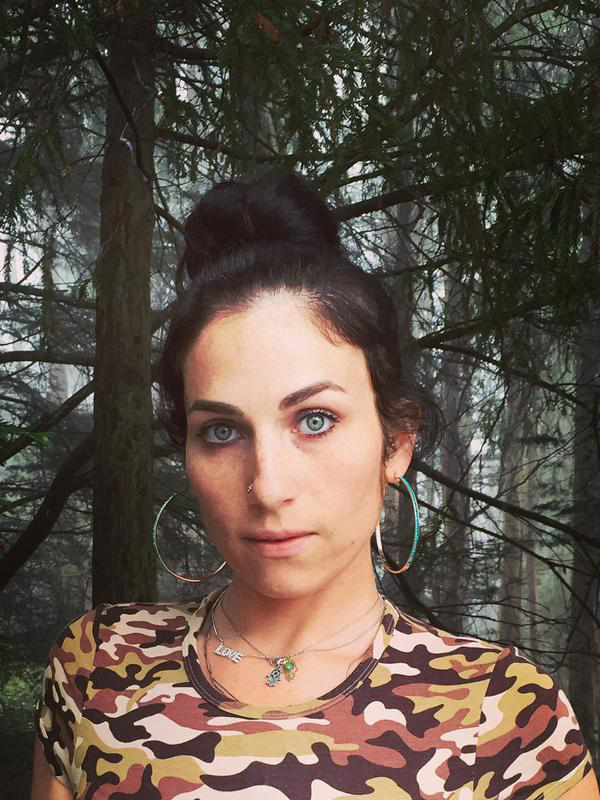

In [ ]:
Image.open('images_data_crop/00507.jpg')

In [ ]:
!cd GT_png && ls

00001_mask.png	00379_mask.png	00757_mask.png	01135_mask.png	02258_mask.png
00002_mask.png	00380_mask.png	00758_mask.png	01136_mask.png	02259_mask.png
00003_mask.png	00381_mask.png	00759_mask.png	01137_mask.png	02260_mask.png
00004_mask.png	00382_mask.png	00760_mask.png	01138_mask.png	02261_mask.png
00005_mask.png	00383_mask.png	00761_mask.png	01139_mask.png	02262_mask.png
00006_mask.png	00384_mask.png	00762_mask.png	01140_mask.png	02263_mask.png
00007_mask.png	00385_mask.png	00763_mask.png	01141_mask.png	02264_mask.png
00008_mask.png	00386_mask.png	00764_mask.png	01142_mask.png	02265_mask.png
00009_mask.png	00387_mask.png	00765_mask.png	01143_mask.png	02266_mask.png
00010_mask.png	00388_mask.png	00766_mask.png	01144_mask.png	02267_mask.png
00011_mask.png	00389_mask.png	00767_mask.png	01145_mask.png	02268_mask.png
00012_mask.png	00390_mask.png	00768_mask.png	01146_mask.png	02269_mask.png
00013_mask.png	00391_mask.png	00769_mask.png	01147_mask.png	02270_mask.png
00014_mask.png	00392_mask

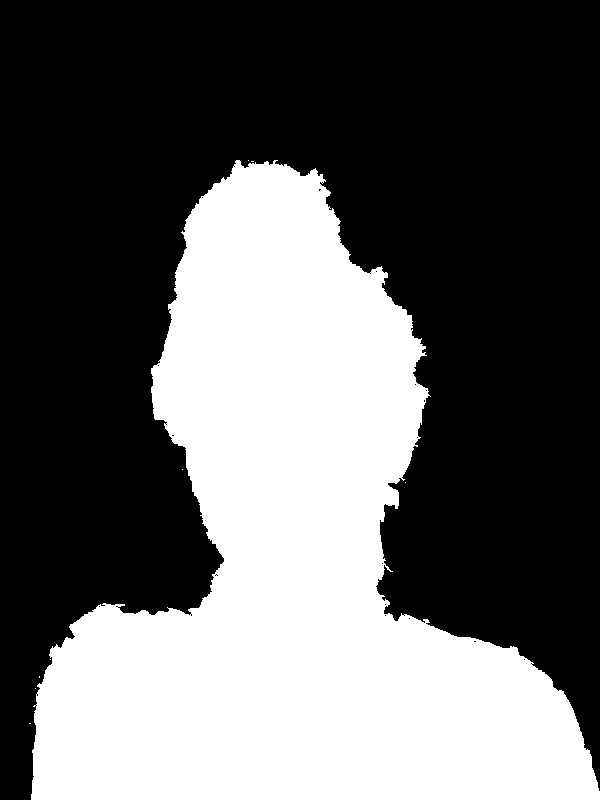

In [ ]:
Image.open('GT_png/00507_mask.png') #00507

In [ ]:
image_extensions = ['jpg','png']

def get_images(path,extensions = image_extensions):
    f" function that returns a list of all files with the given extensions in the given path"
    path = Path(path)
    def endswith(file, ext: list):
        f"returns True if file ends with either of the extensions in the given list"
        res= True
        for o in ext: res = res or file.endswith(o) #string.endswith
        return res
    x = []
    for p,d,f in os.walk(path):
        for file in f:
            if endswith(file,extensions): 
                x.append(Path(p)/file)
    
    return x

In [ ]:
path = Path('')
fnames = get_images(path/'images_data_crop')

In [ ]:
fnames[0] #x

PosixPath('images_data_crop/00917.jpg')

In [ ]:
lbl_names = get_images(path/'GT_png')

In [ ]:
len(fnames),len(lbl_names)

(1630, 1887)

In [ ]:
id = '00485'
im = Image.open(f'images_data_crop/{id}.jpg')
mask = Image.open(f'GT_png/{id}_mask.png')

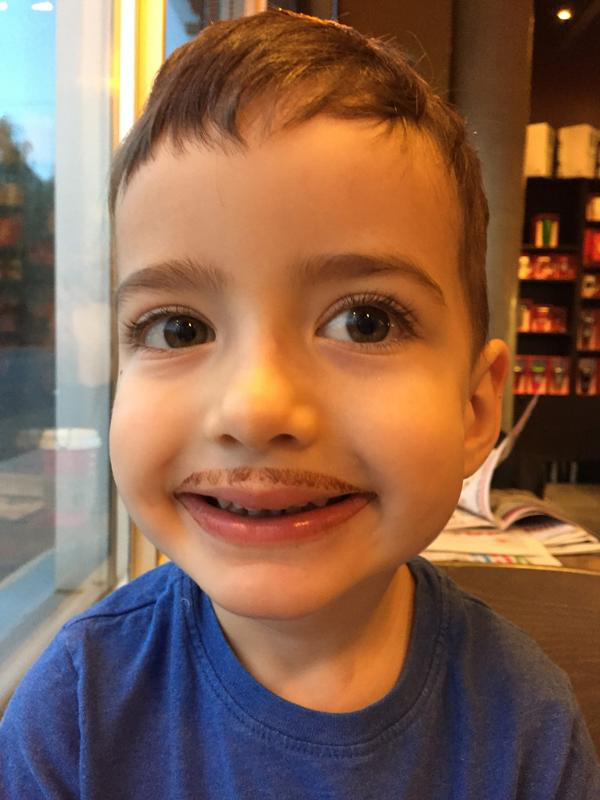

In [ ]:
im

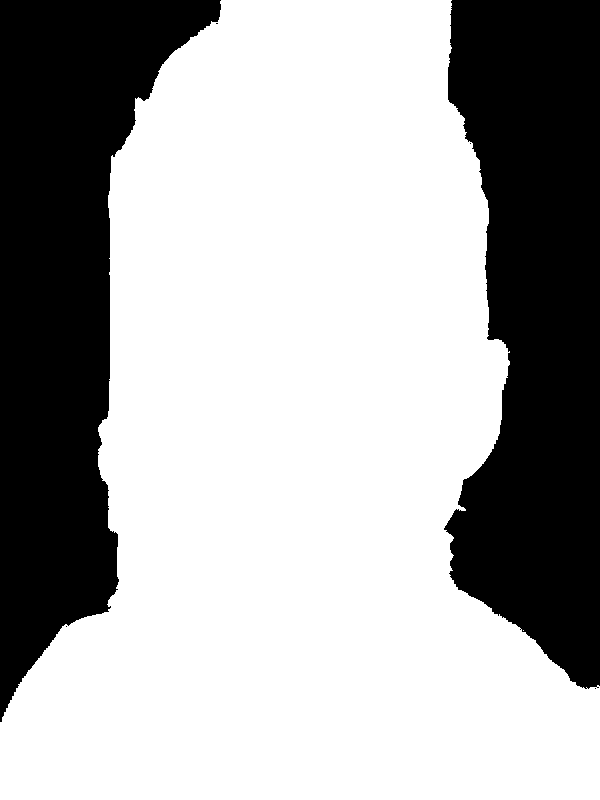

In [ ]:
mask

In [ ]:
def center_crop(image_tsr): return torchvision.transforms.CenterCrop(size=400)(image_tsr) # return images of size 400
def to_tensor(image): return torchvision.transforms.ToTensor()(image)
im_tsr = to_tensor(im)
mask_tsr = to_tensor(mask)

im_tsr.shape, mask_tsr.shape

(torch.Size([3, 800, 600]), torch.Size([1, 800, 600]))

Building my dataset

In [ ]:
from torch.utils.data import Dataset, random_split, DataLoader

class SegmentationDataset(Dataset):
    def __init__(self,x_path,y_fn=None, transforms = None, y_transforms=None):
        self.transforms = ([lambda x: x] if not transforms else transforms)
        self.y_transforms = ([lambda x: x] if not y_transforms else y_transforms)

        self.x_fnames = get_images(x_path) #these are not images, these are paths of files, and we're going to transform them into images on the fly
        self.y_fnames = [y_fn(i) for i in self.x_fnames]
    
    def __len__(self): return len(self.x_fnames)

    def __getitem__(self,i):
        return (self.apply_tfms(self.x_fnames[i],self.transforms), self.apply_tfms(self.y_fnames[i], self.y_transforms))

    
    def apply_tfms(self,x,tfm_list):
        for tfm in tfm_list: 
            x= tfm(x)
        return x

In [ ]:
data = SegmentationDataset(x_path = 'images_data_crop',
                           y_fn = lambda x: Path('GT_png')/f'{x.stem}_mask.png',
                           transforms=[Image.open, 
                                       lambda img: img.convert('RGB'), 
                                       to_tensor,
                                       center_crop],
                           y_transforms = [Image.open,
                                           to_tensor,
                                           center_crop])

                                

In [ ]:
x,y = data[0]
type(x),type(y)

(torch.Tensor, torch.Tensor)

In [ ]:
x.shape

torch.Size([3, 400, 400])

In [ ]:
def split_ds_by_pct(dataset,pct= 0.8):#by default do an 80-20 split
    assert 0.<=pct<=1., f'pct should be a floating point between 0 and 1'
    return random_split(dataset,[int(pct*len(dataset)), (len(dataset)- int(pct*len(dataset)))])

train_ds, val_ds = split_ds_by_pct(data)
len(train_ds),len(val_ds)

(1304, 326)

In [ ]:
train_dl = DataLoader(train_ds, batch_size = 8, shuffle = True)
valid_dl = DataLoader(val_ds, batch_size = 16, shuffle = False)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [ ]:
x,y = next(iter(train_dl))
x.shape,y.shape

(torch.Size([8, 3, 400, 400]), torch.Size([8, 1, 400, 400]))

Model

In [ ]:
class Block(nn.Module):
    def __init__(self,in_ch,out_ch):
        super().__init__()
        self.conv1 = nn.Conv2d(in_ch,out_ch,3)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(out_ch,out_ch,3)

    def forward(self,x):
        layers = [self.conv1,self.relu, self.conv2, self.relu]
        for layer in layers: x = layer(x)
        return x

enc_block = Block(1,64)
x = torch.randn(1,1, 572,572)
enc_block(x).shape

torch.Size([1, 64, 568, 568])

In [ ]:
class Encoder(nn.Module):
    def __init__(self,chs = (3,64, 128, 256, 512, 1024)):
        super().__init__()
        self.enc_blocks = nn.ModuleList([Block(chs[i], chs[i+1]) for i in range(len(chs)-1)])
        self.pool = nn.MaxPool2d(2)

    def forward(self,x):
        ftrs = []
        for block in self.enc_blocks:
            x = block(x)
            ftrs.append(x)
            x = self.pool(x)
        
        return ftrs

In [ ]:
encoder = Encoder()
x = torch.randn(1,3,572,572)
ftrs = encoder(x)
for ftr in ftrs: print(ftr.shape)

torch.Size([1, 64, 568, 568])
torch.Size([1, 128, 280, 280])
torch.Size([1, 256, 136, 136])
torch.Size([1, 512, 64, 64])
torch.Size([1, 1024, 28, 28])


In [ ]:
class Decoder(nn.Module):
    def __init__(self, chs = (1024,512,256,128,64)):
        super().__init__()
        self.chs = chs
        self.up_convs = nn.ModuleList([nn.ConvTranspose2d(chs[i],chs[i+1],2,2) for i in range(len(chs)-1)])
        self.dec_blocks = nn.ModuleList([Block(chs[i],chs[i+1]) for i in range(len(chs)-1)])
    
    def forward(self,x, enc_ftrs):
        enc_ftrs = enc_ftrs[::-1][1:]

        for i in range(len(self.chs)-1):
            x= self.up_convs[i](x)
            ftr = self.crop(enc_ftrs[i],x)
            x = torch.cat([x,ftr], dim=1)
            x = self.dec_blocks[i](x)
        return x
        

    def crop(self, ftr, x):
        _,_,H,W = x.shape
        ftr = torchvision.transforms.CenterCrop([H,W])(ftr)
        return ftr


In [ ]:
decoder = Decoder()
x = torch.randn(1,1024,28,28)
decoder(x,ftrs).shape

torch.Size([1, 64, 388, 388])

Putting them all together in one class

In [ ]:
import torch.nn.functional as F

class Unet(nn.Module):
    def __init__(self, enc_chs, dec_chs, num_out_ch= 1, retain_dim = False, out_sz = (400,400)):
        super().__init__()
        self.encoder = Encoder(enc_chs)
        self.decoder = Decoder(dec_chs)
        self.head    = nn.Conv2d(dec_chs[-1], num_out_ch ,1)

        self.retain_dim = retain_dim
        self.out_sz = out_sz

    def forward(self,x):
        enc_ftrs = self.encoder(x)

        out = self.decoder(enc_ftrs[-1],enc_ftrs)
        out = self.head(out)

        if self.retain_dim:
            out = F.interpolate(out,self.out_sz)
        return out


In [ ]:
enc_chs = (3,64, 128, 256, 512, 1024)
dec_chs = (1024,512,256,128,64)

unet = Unet(enc_chs = enc_chs, dec_chs = dec_chs, retain_dim=True).cuda()
x,y = next(iter(train_dl))
x = x.cuda()
x.shape, unet(x).shape

(torch.Size([8, 3, 400, 400]), torch.Size([8, 1, 400, 400]))

In [ ]:
unet

Unet(
  (encoder): Encoder(
    (enc_blocks): ModuleList(
      (0): Block(
        (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
        (relu): ReLU()
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
      )
      (1): Block(
        (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
        (relu): ReLU()
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
      )
      (2): Block(
        (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
        (relu): ReLU()
        (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
      )
      (3): Block(
        (conv1): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1))
        (relu): ReLU()
        (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1))
      )
      (4): Block(
        (conv1): Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1))
        (relu): ReLU()
        (conv2): Conv2d(1024, 1024, kernel_size=(3, 3), stride=(1, 1))
      )
    )
    

In [ ]:
from tqdm import tqdm

loss_fn = torch.nn.MSELoss()
avg = lambda l: sum(l)/len(l)


class optimizer():
  def __init__(self, params, lr=0.1): self.params, self.lr = list(params), lr
  def step(self):
    with torch.no_grad():
      for p in self.params: 
          p-=self.lr*p.grad

  def zero_grad(self):
    for p in self.params: p.grad.data.zero_()




class Learner():
  def __init__(self,train_dl,valid_dl,model,optimizer=None): #remove default value of model
    self.train_dl=train_dl
    self.valid_dl=valid_dl
    self.model=model.to(device)
    self.opt=optimizer(self.model.parameters()) if not optimizer else optimizer

  def fit(self,epochs=1, bs=64,lr=None,loss_func=torch.nn.BCEWithLogitsLoss()):
    lr=self.opt.lr if not lr else lr
    for epoch in range(epochs):


      loss_train_list = [] 
      for x,y in tqdm(train_dl):
        x,y=x.cuda(),y.cuda()
        # x=preprocess(x)

        loss = loss_func(self.model(x),y)
        loss.backward()

        loss_train_list.append(loss)


        self.opt.step()
        self.opt.zero_grad()





      loss_val_list=[]

      for x,y in list(valid_dl):
        x,y = x.cuda(),y.cuda()
        
        with torch.no_grad():
            loss_val_list.append(loss_func(self.model(x),y))
    print(f'epoch {epoch+1}: training loss: {avg(loss_train_list)}, validation loss: {avg(loss_val_list)}')
  def predict(self,x): return torch.argmax(self.model(x),dim=1)



model = Unet(enc_chs = enc_chs, dec_chs = dec_chs, retain_dim=True)
opt=optimizer(model.parameters())
model

Unet(
  (encoder): Encoder(
    (enc_blocks): ModuleList(
      (0): Block(
        (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
        (relu): ReLU()
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
      )
      (1): Block(
        (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
        (relu): ReLU()
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
      )
      (2): Block(
        (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
        (relu): ReLU()
        (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
      )
      (3): Block(
        (conv1): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1))
        (relu): ReLU()
        (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1))
      )
      (4): Block(
        (conv1): Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1))
        (relu): ReLU()
        (conv2): Conv2d(1024, 1024, kernel_size=(3, 3), stride=(1, 1))
      )
    )
    

In [ ]:
learn = Learner(train_dl, valid_dl, model, optimizer = opt)

In [ ]:
learn.fit(1)

100%|██████████| 163/163 [05:10<00:00,  1.91s/it]


epoch 1: training loss: 0.48210597038269043, validation loss: 0.49866437911987305
